# Análise Geoespacial - Filiação Partidária Por Município no Rio de Janeiro

Este notebook é parte de um **Projeto de Uso de Dados Públicos Eleitorais e Partidários** que participei como Assistente de Pesquisa. Como o mesmo ainda não foi divulgado, pedi permissão para o Professor responsável para utilizar este pequeno pedaço como Portfólio.

Neste recorte estão inclusos:

 -  Limpeza e Organização dos Dados
 - Visualização com Geopandas - Quantidade de Filiados por Municipio
 - Análise de Correlação Espacial
 
#### Sobre os dadoos:

O arquivo *dados_filia_rj.csv* foi construido exclusivamento com arquivos baixados do portal do [TSE - Tribunal Superior Eleitoral](http://www.tse.jus.br/partidos/filiacao-partidaria/relacao-de-filiados). Como não é possível baixar os dados de filiação de todos os partidos ao mesmo tempo foi utilizado um script para aquisição dos dados, este script foi baseado no arquivo *filiacao_download.py* do [Github do Álvaro Justen](https://github.com/turicas/eleicoes-brasil).

In [48]:
#importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import libpysal as lps
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.5f}'.format

In [27]:
#Importando os dados
dados_filia_rj=pd.read_csv('dados_filia_rj.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
#copia para um outro dataframe, para trabalhar os dados
dados_geo=dados_filia_rj.copy()

# Limpesa e Organização dos Dados

- A coluna **'Tipo de Registro'** separa as filiações em **'Oficiais'** e **'Sub Judice'**. Para a presente pesquisa, todavia, serão consideradas apenas filiações oficiais.
- Como não trabalharemos com as filiações **'Sub Judice'**, também não trabalharemos com a data de sua eventual regularização
- Em nome da simplicidade, uniremos as colunas **'Data da Desfiliação'** e **'Data do Cancelamento'** em uma única variável **'Data da Saída'**. O TSE faz tal separação interna por considerar como 'desligado' aquele membro que saiu (ou foi expulso) do partido sem que tenha sido registrado devidamente como tal saída foi feita. Nos raros casos em que há o registro de data em ambos os campos, mostram os manuais do TSE que, para fins legais, a data efetiva da saída do membro seria a data mais recente das duas.


In [29]:
#limpando colunas que não serão utilizadas
dados_geo.drop(['DATA DA EXTRACAO','HORA DA EXTRACAO', 'DATA DA REGULARIZACAO', 'Unnamed: 0'], axis=1, inplace=True)

In [30]:
#transformando os campos para o formato de data
dados_geo[['DATA DA FILIACAO','DATA DO PROCESSAMENTO', 'DATA DA DESFILIACAO','DATA DO CANCELAMENTO']
          ]= dados_geo[['DATA DA FILIACAO','DATA DO PROCESSAMENTO', 'DATA DA DESFILIACAO','DATA DO CANCELAMENTO']
                       ].apply(pd.to_datetime, format='%d/%m/%Y', errors = 'coerce').copy()

## Datas de Filiação
No campo **'DATA DA FILIACAO'** encontramos registros com datas irreais, como de antes da existencia de Partidos até datas futuras. 

In [34]:
print(dados_geo['DATA DA FILIACAO'].min())
print(dados_geo['DATA DA FILIACAO'].max())

1899-12-30 00:00:00
2206-04-18 00:00:00


Por isso iremos restringir os dados com **'DATA DA FILIACAO'** dentro do seguinte intervalo 1980-2019

In [8]:
start_date = '01/01/1980'
end_date = '31/12/2019'
mask = (dados_geo['DATA DA FILIACAO'] >= start_date) & (dados_geo['DATA DA FILIACAO'] <= end_date)
dados_geo = dados_geo.loc[mask]
dados_geo

,NUMERO DA INSCRICAO,NOME DO FILIADO,SIGLA DO PARTIDO,NOME DO PARTIDO,UF,CODIGO DO MUNICIPIO,NOME DO MUNICIPIO,ZONA ELEITORAL,SECAO ELEITORAL,DATA DA FILIACAO,SITUACAO DO REGISTRO,TIPO DO REGISTRO,DATA DO PROCESSAMENTO,DATA DA DESFILIACAO,DATA DO CANCELAMENTO,MOTIVO DO CANCELAMENTO
0,8802880329,JORGE SANTANA QUEIROZ,AVANTE,AVANTE,RJ,60011,RIO DE JANEIRO,162,316.00000,1995-12-15,CANCELADO,OFICIAL,NaT,NaT,2019-10-15,CANCELAMENTO AUTOMÁTICO
1,51014240361,MARIA LUCIA VALENTE BREIJAO,AVANTE,AVANTE,RJ,58335,DUQUE DE CAXIAS,128,61.00000,1990-03-07,CANCELADO,OFICIAL,NaT,NaT,NaT,NaN
2,62324490370,MARIA JOSÉ CORREA AGUIAR,AVANTE,AVANTE,RJ,58173,CAMBUCI,97,5.00000,1999-09-29,CANCELADO,OFICIAL,NaT,NaT,2011-12-12,JUDICIAL
3,1470160370,MARIA DE LOURDES CASTRO,AVANTE,AVANTE,RJ,59234,VASSOURAS,41,125.00000,1998-05-02,CANCELADO,OFICIAL,NaT,2011-05-30,2011-05-30,A PEDIDO DO ELEITOR
4,6209090329,ADILSON RABELO DE BRITO,AVANTE,AVANTE,RJ,60011,RIO DE JANEIRO,169,194.00000,1995-05-05,CANCELADO,OFICIAL,NaT,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465198,76920880370,MARIZA BARBOSA CORREIA,SOLIDARIEDADE,SOLIDARIEDADE,RJ,59153,TERESÓPOLIS,38,182.00000,2016-07-23,REGULAR,OFICIAL,NaT,NaT,NaT,NaN
1465199,73512780388,ROGERIO DE SOUZA ILDEBRANDO,SOLIDARIEDADE,SOLIDARIEDADE,RJ,58939,SANTO ANTÔNIO DE PÁDUA,34,3.00000,2015-03-13,REGULAR,OFICIAL,NaT,NaT,NaT,NaN
1465200,17793640353,PAULO BERARDO MASSET,SOLIDARIEDADE,SOLIDARIEDADE,RJ,60011,RIO DE JANEIRO,211,32.00000,2018-03-15,REGULAR,OFICIAL,NaT,NaT,NaT,NaN
1465201,74364920388,PATRICIA OLIVIER DE PAULA SIQUEIRA,SOLIDARIEDADE,SOLIDARIEDADE,RJ,58653,NITERÓI,72,454.00000,2016-06-30,REGULAR,OFICIAL,NaT,NaT,NaT,NaN


In [9]:
#criação da coluna Data da Saida
dados_geo['DATA_DA_SAIDA']=dados_geo['DATA DA DESFILIACAO'].combine(dados_geo['DATA DO CANCELAMENTO'], lambda a, b: a if((~pd.isnull(a)) and a>b) else b)
dados_geo[['DATA_DA_SAIDA', 'DATA DA DESFILIACAO', 'DATA DO CANCELAMENTO']].head(20)

,DATA_DA_SAIDA,DATA DA DESFILIACAO,DATA DO CANCELAMENTO
0,2019-10-15,NaT,2019-10-15
1,NaT,NaT,NaT
2,2011-12-12,NaT,2011-12-12
3,2011-05-30,2011-05-30,2011-05-30
4,NaT,NaT,NaT
5,NaT,NaT,NaT
6,NaT,NaT,NaT
7,NaT,NaT,NaT
8,NaT,NaT,NaT
9,2019-10-16,2011-07-20,2019-10-16


In [10]:
#retirada das colunas Data da Desfiliação e Data do Cancelamento que foram subistituidas por Data da Saida
dados_geo.drop(['DATA DA DESFILIACAO', 'DATA DO CANCELAMENTO'], axis=1, inplace=True)

In [11]:
#Criando colunas de Dia, Mes, Ano para cada linha - Facilita agregações
dados_geo['MES_FILIACAO'] = dados_geo['DATA DA FILIACAO'].map(lambda x: x.month)
dados_geo['ANO_FILIACAO'] = dados_geo['DATA DA FILIACAO'].map(lambda x: x.year)
dados_geo['DIA_FILIACAO'] = dados_geo['DATA DA FILIACAO'].map(lambda x: x.day)

In [12]:
dados_geo.shape

(1460732, 18)

In [13]:
dados_geo.head(3)

,NUMERO DA INSCRICAO,NOME DO FILIADO,SIGLA DO PARTIDO,NOME DO PARTIDO,UF,CODIGO DO MUNICIPIO,NOME DO MUNICIPIO,ZONA ELEITORAL,SECAO ELEITORAL,DATA DA FILIACAO,SITUACAO DO REGISTRO,TIPO DO REGISTRO,DATA DO PROCESSAMENTO,MOTIVO DO CANCELAMENTO,DATA_DA_SAIDA,MES_FILIACAO,ANO_FILIACAO,DIA_FILIACAO
0,8802880329,JORGE SANTANA QUEIROZ,AVANTE,AVANTE,RJ,60011,RIO DE JANEIRO,162,316.00000,1995-12-15,CANCELADO,OFICIAL,NaT,CANCELAMENTO AUTOMÁTICO,2019-10-15,12,1995,15
1,51014240361,MARIA LUCIA VALENTE BREIJAO,AVANTE,AVANTE,RJ,58335,DUQUE DE CAXIAS,128,61.00000,1990-03-07,CANCELADO,OFICIAL,NaT,NaN,NaT,3,1990,7
2,62324490370,MARIA JOSÉ CORREA AGUIAR,AVANTE,AVANTE,RJ,58173,CAMBUCI,97,5.00000,1999-09-29,CANCELADO,OFICIAL,NaT,JUDICIAL,2011-12-12,9,1999,29


# Agrupando Os Dados

Até o momento temos um dataset com mais de 14 milhões de linhas, cada uma representando uma filiação que pode ou não estar válida.

Nesta análise teremos que manter os registros com status 'CANCELADO' pois queremos ter uma visão de magnitude de filiações no tempo. Isto é, uma filiação que foi feita em 1980 e já foi cancelada, tem que ser considerada para medir o número total de filiações de um município.

Para obter uma visão de evolução no tempo irei comparar os anos de 2010 e 2019.

In [35]:
#dados 2019
fili_cidade_2019 = dados_geo.groupby(['CODIGO DO MUNICIPIO','NOME DO MUNICIPIO'], as_index=False).size().to_frame(name = 'QTD_FILIADOS_2019').reset_index()
print(fili_cidade_2019.shape)
fili_cidade_2019.head(3)

(92, 3)


,CODIGO DO MUNICIPIO,NOME DO MUNICIPIO,QTD_FILIADOS_2019
0,58009,QUISSAMÃ,4287
1,58017,ANGRA DOS REIS,20320
2,58025,QUATIS,3296


In [38]:
#dados 2010
end_date = '31/12/2010'
mask = (dados_geo['DATA DA FILIACAO'] <= end_date)
dados_2010 = dados_geo.loc[mask]

In [39]:
fili_cidade_2010 = dados_2010.groupby(['CODIGO DO MUNICIPIO','NOME DO MUNICIPIO'], as_index=False).size().to_frame(name = 'QTD_FILIADOS_2010').reset_index()
print(fili_cidade_2010.shape)
fili_cidade_2010.head(3)

(92, 3)


,CODIGO DO MUNICIPIO,NOME DO MUNICIPIO,QTD_FILIADOS_2010
0,58009,QUISSAMÃ,2577
1,58017,ANGRA DOS REIS,14866
2,58025,QUATIS,2486


Importando o mapa do Estado do Rio de Janeiro

In [40]:
mapa_rj = gpd.read_file('33MUE250GC_SIR.shp')

In [41]:
fili_cidade_2019 = pd.merge(fili_cidade_2019, mapa_rj, how='inner', left_on='NOME DO MUNICIPIO', right_on='NM_MUNICIP')
print(fili_cidade_2019.shape)
fili_cidade_2010 = pd.merge(fili_cidade_2010, mapa_rj, how='inner', left_on='NOME DO MUNICIPIO', right_on='NM_MUNICIP')
fili_cidade_2010.shape

(92, 6)


(92, 6)

In [42]:
fili_cidade_2019.drop('NM_MUNICIP', axis=1, inplace=True)
fili_cidade_2010.drop('NM_MUNICIP', axis=1, inplace=True)

In [43]:
fili_cidade_2019 = gpd.GeoDataFrame(fili_cidade_2019, geometry='geometry', crs=mapa_rj.crs)
fili_cidade_2010 = gpd.GeoDataFrame(fili_cidade_2010, geometry='geometry', crs=mapa_rj.crs)

In [44]:
print(type(fili_cidade_2019))
type(fili_cidade_2016)

<class 'geopandas.geodataframe.GeoDataFrame'>


geopandas.geodataframe.GeoDataFrame

In [45]:
fili_cidade_2019.head(3)

,CODIGO DO MUNICIPIO,NOME DO MUNICIPIO,QTD_FILIADOS_2019,CD_GEOCMU,geometry
0,58009,QUISSAMÃ,4287,3304151,"POLYGON ((-41.59112 -22.13296, -41.59532 -22.1..."
1,58017,ANGRA DOS REIS,20320,3300100,"MULTIPOLYGON (((-44.15109 -23.21602, -44.15076..."
2,58025,QUATIS,3296,3304128,"POLYGON ((-44.27505 -22.40440, -44.27513 -22.4..."


In [46]:
fili_cidade_2010.head(3)

,CODIGO DO MUNICIPIO,NOME DO MUNICIPIO,QTD_FILIADOS_2010,CD_GEOCMU,geometry
0,58009,QUISSAMÃ,2577,3304151,"POLYGON ((-41.59112 -22.13296, -41.59532 -22.1..."
1,58017,ANGRA DOS REIS,14866,3300100,"MULTIPOLYGON (((-44.15109 -23.21602, -44.15076..."
2,58025,QUATIS,2486,3304128,"POLYGON ((-44.27505 -22.40440, -44.27513 -22.4..."


# Visualização

Vou plotar ambos os gráficos lado a lado para compararmos a evolução do número de filiações

(-45.08588953274997,
 -40.761371934249986,
 -23.499218287049974,
 -20.632919135949923)

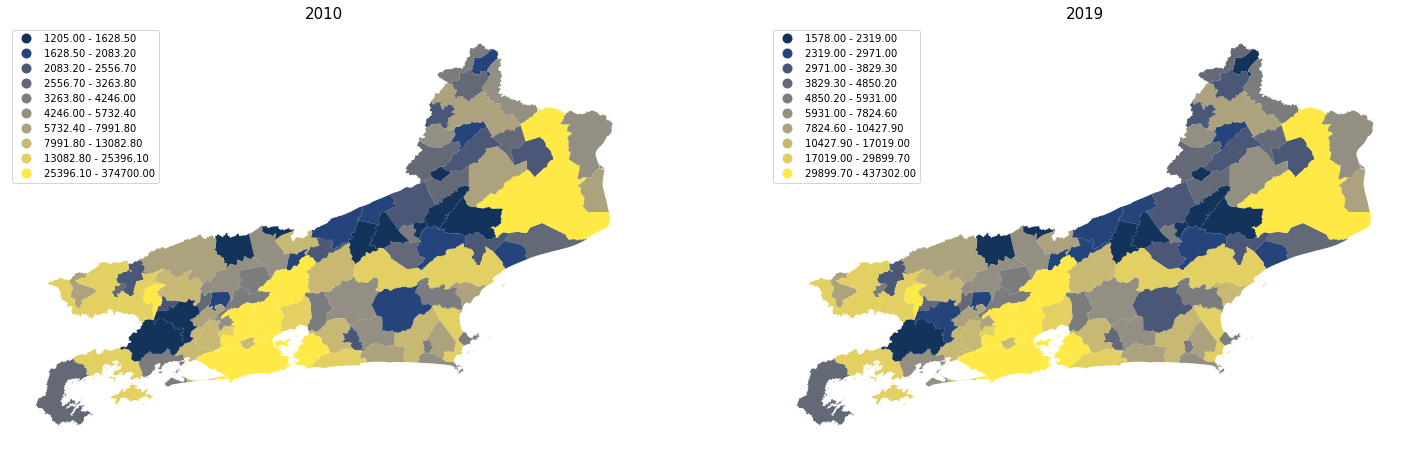

<Figure size 2160x2160 with 0 Axes>

In [47]:
plt.rcParams['figure.figsize'] = [25, 25]
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.figure(figsize=(30, 30))
# We can now plot our ``GeoDataFrame``.
fili_cidade_2010.plot(column='QTD_FILIADOS_2010', legend=True, ax=ax1, alpha = 0.92, scheme='QUANTILES',
                 k=10, cmap='cividis',linewidth=2, legend_kwds={'loc': 'upper left'})
fili_cidade_2019.plot(column='QTD_FILIADOS_2019', legend=True, ax=ax2, alpha = 0.92, scheme='QUANTILES',
                 k=10, cmap='cividis',linewidth=2, legend_kwds={'loc': 'upper left'})
ax1.set_title("2010", fontsize=15)
ax2.set_title("2019", fontsize=15)
ax1.axis('off')
ax2.axis('off')

É interessante notar que apesar dos números absolutos (legendas) crescerem signitivamente nestes quase 10 anos, a distribuição parece permanecer a mesma. 

# Testes Autocorrelação Espacial

#### Teste de Correlação Espacial de Moran's:
O Indice Moran de Correlação é um coeficiente que mede a corrlação espacial média de um conjunto de datos, em outras palavras, mede quão similares entre si são os dados e suas redondezas. Ele possui um range de -1 a 1  onde:
- -1 é um cluster perfeito de dados muito diferentes, seria uma dispersão perfeita.
- 0 indica que não há correlação, seria uma amostra perfeitamente randômica.
- 1 é um cluster perfeito de dados similares, seria como se todos os dados fossem muito próximos.


In [49]:
w_2019 = lps.weights.Queen.from_dataframe(fili_cidade_2019)
w_2019.transform = "R"
w_2010 = lps.weights.Queen.from_dataframe(fili_cidade_2010)
w_2010.transform = "R"

In [61]:
y_2019 = fili_cidade_2019['QTD_FILIADOS_2019']
moran_2019 = Moran(y_2019, w_2019)
print(moran_2010.I)
y_2010 = fili_cidade_2010['QTD_FILIADOS_2010']
moran_2010 = Moran(y_2010, w_2010)
moran_2019.I

0.08045044135501334


0.09485658906888392

O teste de autocorrelação Moran mostra que nossa amostra é bastante randômica, porém há um pequeno aumento da clusterização

Text(0.5, 1.0, 'Moran Sactterplot 2019 (0.09)')

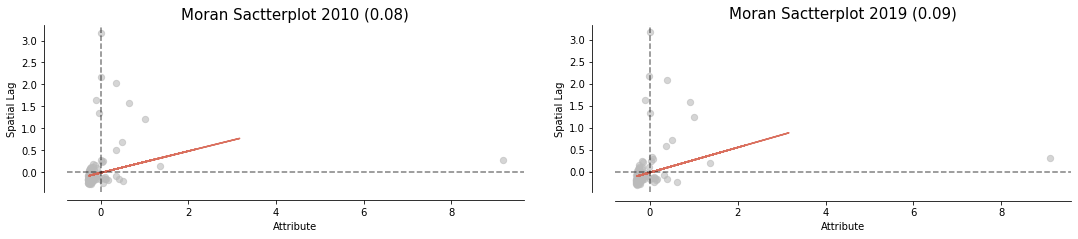

In [52]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,18), subplot_kw={'aspect': 'equal'})
moran_scatterplot(moran_2010, aspect_equal=True, ax=ax1)
moran_scatterplot(moran_2019, aspect_equal=True, ax=ax2)

ax1.set_title("Moran Sactterplot 2010 ({})".format(round(moran_2010.I,2)), fontsize=15)
ax2.set_title("Moran Sactterplot 2019 ({})".format(round(moran_2019.I,2)), fontsize=15)

#### Teste de Autocorrelação Espacial Local de Moran's

Este indice é derivado do anterior, a diferença é que se o primeiro é um coeficiente que analisa o dataset como um todo, este diz para cada unidade analisada quão similar ela é do seu entorno, no nosso caso a unidade é o municipio.

E ele indica clusters estatisticamente relevantes de até 4 tipos:

- Low-Low: Unidades abaixo da média, no nosso caso média de quantidade de filiados, que possuem unidades abaixo da média ao redor
- High-High: Unidades acima da média, que possuem unidades acima da média ao redor
- Low-High: Unidades abaixo da média, que possuem unidades acima da média ao redor
- High-Low:  Unidades acima da média, que possuem unidades abaixo da média ao redor

In [63]:
# calculate Moran Local 
m_local_2010 = Moran_Local(y_2010, w_2010)
m_local_2019 = Moran_Local(y_2019, w_2019)

Text(0.5, 1.0, 'Moran Local Sactterplot 2019')

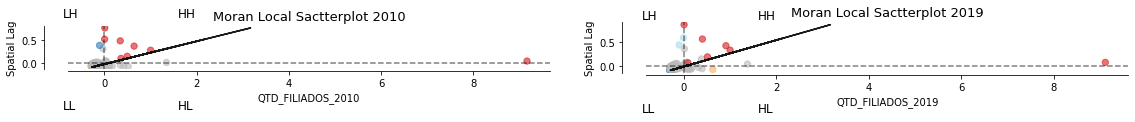

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,19), subplot_kw={'aspect': 'equal'})
moran_scatterplot(m_local_2010, p=0.05, ax=ax1)
moran_scatterplot(m_local_2019, p=0.05, ax=ax2)

#fig, ax = moran_scatterplot(m_local, p=0.05)
ax1.set_xlabel('QTD_FILIADOS_2010')
#fig, ax = moran_scatterplot(m_local, p=0.05)
ax2.set_xlabel('QTD_FILIADOS_2019')
#ax.set_ylabel('Spatial Lag of QTD_INGRESSO')
ax1.text(1.6, 1, 'HH', fontsize=12)
ax1.text(1.6, -1, 'HL', fontsize=12)
ax1.text(-0.9, 1, 'LH', fontsize=12)
ax1.text(-0.9, -1, 'LL', fontsize=12)
ax2.text(1.6, 1, 'HH', fontsize=12)
ax2.text(1.6, -1, 'HL', fontsize=12)
ax2.text(-0.9, 1, 'LH', fontsize=12)
ax2.text(-0.9, -1, 'LL', fontsize=12)
ax1.set_title("Moran Local Sactterplot 2010", fontsize=13)
ax2.set_title("Moran Local Sactterplot 2019", fontsize=13)

Text(0.5, 1, '2019')

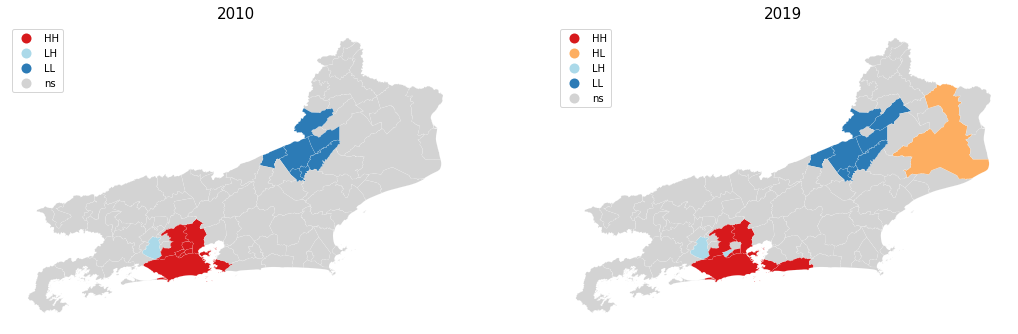

In [65]:
from splot.esda import lisa_cluster
'''High-High, High-Low, Low-High, Low-Low, Not Significant '''

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,18), subplot_kw={'aspect': 'equal'})
lisa_cluster(m_local_2010, fili_cidade_2010, p=0.05, figsize = (14,13), legend_kwds={'loc': 'upper left'}, ax=ax1)
lisa_cluster(m_local_2019, fili_cidade_2019, p=0.05, figsize = (14,13), legend_kwds={'loc': 'upper left'}, ax=ax2)

ax1.set_title("2010", fontsize=15)
ax2.set_title("2019", fontsize=15)


Interessante notar como algumas cidades mudaram de cluster e o aparecimento de um novo cluster *High-Low*.